## All you need is love… And a pet!

<img src="img/dataset-cover.jpg" width="920">

Here we are going to build a classifier to predict whether an animal from an animal shelter will be adopted or not (aac_intakes_outcomes.csv, available at: https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/version/1#aac_intakes_outcomes.csv). You will be working with the following features:

1. *animal_type:* Type of animal. May be one of 'cat', 'dog', 'bird', etc.
2. *intake_year:* Year of intake
3. *intake_condition:* The intake condition of the animal. Can be one of 'normal', 'injured', 'sick', etc.
4. *intake_number:* The intake number denoting the number of occurrences the animal has been brought into the shelter. Values higher than 1 indicate the animal has been taken into the shelter on more than one occasion.
5. *intake_type:* The type of intake, for example, 'stray', 'owner surrender', etc.
6. *sex_upon_intake:* The gender of the animal and if it has been spayed or neutered at the time of intake
7. *age_upon\_intake_(years):* The age of the animal upon intake represented in years
8. *time_in_shelter_days:* Numeric value denoting the number of days the animal remained at the shelter from intake to outcome.
9. *sex_upon_outcome:* The gender of the animal and if it has been spayed or neutered at time of outcome
10. *age_upon\_outcome_(years):* The age of the animal upon outcome represented in years
11. *outcome_type:* The outcome type. Can be one of ‘adopted’, ‘transferred’, etc.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from itertools import combinations 
import ast
from sklearn.linear_model import LogisticRegression
import seaborn as sn
%matplotlib inline

data_folder = './data/'

### A) Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). 
- Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. 
- Standardize the values of each feature in the data to have mean 0 and variance 1.

The use of external libraries is not permitted in part A, except for numpy and pandas. 
You can drop entries with missing values.

In [2]:
columns = ['animal_type', 'intake_year', 'intake_condition', 'intake_number', 'intake_type', 'sex_upon_intake', \
          'age_upon_intake_(years)', 'time_in_shelter_days', 'sex_upon_outcome', 'age_upon_outcome_(years)', \
          'outcome_type']
original_data = pd.read_csv(data_folder+'aac_intakes_outcomes.csv', usecols=columns)

In [3]:
# Remove NaN
print("Lengths before: %d" % (len(original_data)))
original_data.dropna(inplace=True)
print("Lengths aftter: %d" % (len(original_data)))

Lengths before: 79672
Lengths aftter: 79661


In [4]:
# Copy original data set 
data = original_data.copy()
# Create handy column to know if an animal was adopted or not and drop 'outcome_type'
data['adopted'] = data['outcome_type'].apply(lambda x: 1 if x=="Adoption" else 0)
data.drop('outcome_type', axis=1, inplace=True)

In [5]:
# Sample 80% of the dataset to make up the training set
training_sample = data.sample(frac=0.8)
# Take the remainig 20% for the testing set
testing_sample = data.drop(training_sample.index)

# Reset the indices
training_sample.reset_index(drop=True, inplace=True)
testing_sample.reset_index(drop=True, inplace=True)

In [6]:
# Extract categorical columns as dummies
categorical_columns = ['sex_upon_outcome', 'animal_type', 'intake_condition',
                       'intake_type', 'sex_upon_intake']
training_sample = pd.get_dummies(training_sample, columns=categorical_columns)
testing_sample = pd.get_dummies(testing_sample, columns=categorical_columns)[training_sample.columns] # Make sure to only keep columns that are in thetraining set

In [7]:
# Extract training labels 
train_labels = training_sample.adopted
test_labels = testing_sample.adopted

# Drop the adopted columns from the features
train_features = training_sample.drop('adopted', axis=1)
test_features = testing_sample.drop('adopted', axis=1)

print("Training set size: %d\nTesting set size: %d" % (len(train_features), len(test_features)))

Training set size: 63729
Testing set size: 15932


In [8]:
# Standardize features
means = train_features.mean()
stddvs = train_features.std()

train_features_std = pd.DataFrame()
for c in train_features.columns:
    train_features_std[c] = (train_features[c] - means[c]) / stddvs[c]

# Also standarize testing set but using training mean and std
test_features_std = pd.DataFrame()
for c in test_features.columns:
    test_features_std[c] = (test_features[c] - means[c]) / stddvs[c]

### B) Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. 
- For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. 

In [20]:
def compute_confusion_matrix(true, pred):
    TP = np.sum(np.logical_and(pred==1, true==1))
    TN = np.sum(np.logical_and(pred==1, true==0))
    FN = np.sum(np.logical_and(pred==0, true==1))
    FP = np.sum(np.logical_and(pred==1, true==0))

    return TP, TN, FN, FP

def compute_scores(TP, TN, FN, FP):
    accuracy = (TP + TN) / (TP + TN + FN + FP)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1

In [11]:
lr = LogisticRegression(max_iter=10000)
lr.fit(train_features_std, train_labels)

LogisticRegression(max_iter=10000)

### C) Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold.

In [17]:
predictions = lr.predict_proba(test_features_std)
predictions

array([[0.84509642, 0.15490358],
       [0.91873106, 0.08126894],
       [0.98982659, 0.01017341],
       ...,
       [0.9938007 , 0.0061993 ],
       [0.93611361, 0.06388639],
       [0.98635191, 0.01364809]])

In [21]:
threshold = 0
thresholds = []
accuracies = []
precisions = []
recalls = []
f1s = []

while threshold <= 1:

    # Classify the probabilities according to the threshold
    classified = (predictions[:,1] > threshold).astype(int)

    # Compute the confusion matrix
    TP, TN, FN, FP = compute_confusion_matrix(test_labels, classified)

    # Compute metrics
    accuracy, precision, recall, f1 = compute_scores(TP, TN, FN, FP )

    # Store the computed scores to plot later    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    # Store the threshold use and increment it
    thresholds.append(threshold)
    threshold += 0.1

/tmp/ipykernel_24755/3009575383.py:11: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)


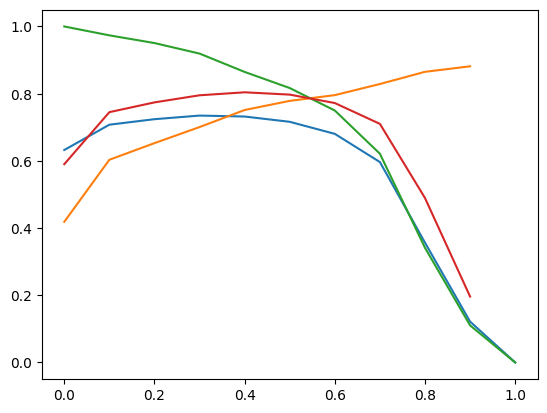

In [25]:
# Plot the values
plt.plot(thresholds, accuracies)
plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
plt.plot(thresholds, f1s)

### D) Plot in a bar chart the coefficients of the logistic regression sorted by their contribution to the prediction.

In [42]:
tmp = []
for name, value in zip(test_features_std.columns, lr.coef_[0]):
    tmp.append({"name": name, "value": value})

coeffs = pd.DataFrame(tmp).sort_values("value")
coeffs.head()

,name,value
1,age_upon_intake_(years),-1.836972
26,intake_type_Wildlife,-0.781272
6,sex_upon_outcome_Intact Male,-0.775625
5,sex_upon_outcome_Intact Female,-0.678632
31,sex_upon_intake_Unknown,-0.495180


<BarContainer object of 32 artists>

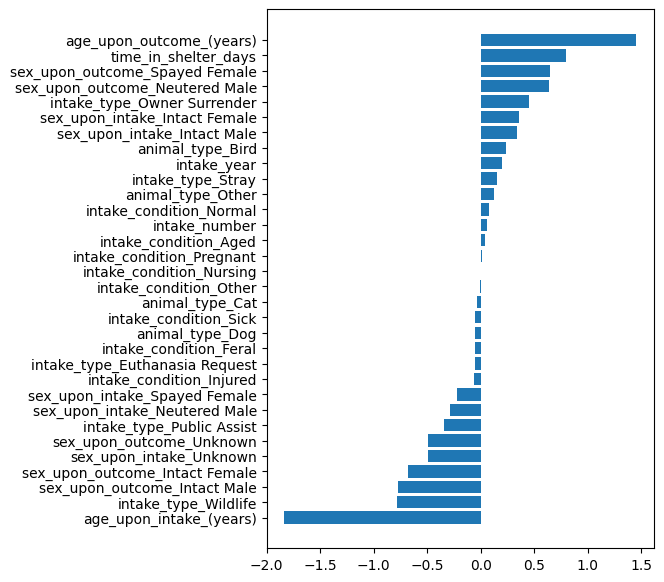

In [44]:
plt.subplots(figsize=(5,7))
plt.barh(coeffs.name, coeffs.value)


## Question 1: Which of the following metrics is most suitable when you are dealing with unbalanced classes?

- a) F1 Score
- b) Recall
- c) Precision
- d) Accuracy

In [49]:
print("A (but why??)")

A (but why??)


## Question 2: You are working on a binary classification problem. You trained a model on a training dataset and got the following confusion matrix on the test dataset. What is true about the evaluation metrics (rounded to the second decimal point):

|            | Pred = NO|Pred=YES|
|------------|----------|--------|
| Actual NO  |    50    |   10   |
| Actual YES |    5     |   100  |

- a) Accuracy is 0.95
- b) Accuracy is 0.85
- c) False positive rate is 0.95
- d) True positive rate is 0.95

In [48]:
TP = 100
FN = 5
TN = 50
FP = 10

acc = (TP + TN) / (TP + TN + FN + FP)
fprate = FP / (FP + TN)
tprate = TP / (TP + FN)

print(acc, fprate, tprate)

print ("D is correct")

0.9090909090909091 0.16666666666666666 0.9523809523809523
D is correct
